In [19]:
#Matplotlib library plots your data
#NumPy library to process large numerical matrixes (images)
import matplotlib.pyplot as plt
import numpy as np


In [20]:
#PyTorch library to train and process deep learning and AI models
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

In [21]:
#Torchvision to process images and do manipulations like cropping and resizing
import torchvision
from torchvision import datasets, transforms, models

In [22]:
#Python Imaging Library (PIL) so you can visualize the images:
from PIL import Image

In [23]:
#add code to import two libraries that ensure the plots are shown inline and with high resolution
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [24]:
# Tells the machine what folder contains the image data.
data_dir = './data'

# Transform the new image into numbers and resize it.
train_transforms = transforms.Compose([
                                #This will extract a patch of size (224, 224) from the input image randomly. 
                                transforms.RandomResizedCrop(224),
                                #Resize image to be 224x224
                                transforms.Resize(224),
                                #Converts the image to PyTorch tensor.
                                transforms.ToTensor(),
                                ])

test_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.Resize(224),
                                    transforms.ToTensor(),
                                ])

In [25]:
# Function to read the data; crop and resize the images; and then split it into test and train chunks.
def load_split_train_test(datadir, valid_size = .2):
    #Get the images from the data folder. Pass in a function/transform that takes in an PIL 
    # image and returns a transformed version
    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)

    #should get 155 images from our data set (91 Basalt and 64 Highland)
    num_train = len(train_data)
    #Create a list of all index numbers of the data set: 0 to 154
    indices = list(range(num_train))
    #155 images * 20 percent holdback = 31 images to use for testing
    split = int(np.floor(valid_size * num_train))
    #Randomly shuffle the list of indices to mix them all up
    np.random.shuffle(indices)
    #Training set is 31 to 154, testing set is 0 to 30
    train_idx, test_idx = indices[split:], indices[:split]
    #Samples elements randomly from a given list of indices, without replacement
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    #Load the data
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)
    return trainloader, testloader

In [26]:
# A function to randomly select a set of images.
def get_random_images(datadir, num):
    #Get the images in the folder
    data = datasets.ImageFolder(datadir, transform=test_transforms)
    #Get the classifications for the images
    classes = data.classes
    #Get the number of images and explode indices into a list
    indices = list(range(len(data)))
    #Shuffle the list to mix up the indexes randomly
    np.random.shuffle(indices)
    #Get the indexes we want to show
    idx = indices[:num]
    #Samples elements randomly from a given list of indices, without replacement
    sampler = SubsetRandomSampler(idx)
    #load the images
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    #Iterate over the image and get the images and labels and return them
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [27]:
# Load the data sets and separate into training and testing sets. We're using 20% of data for testing.
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['Basalt', 'Highland']


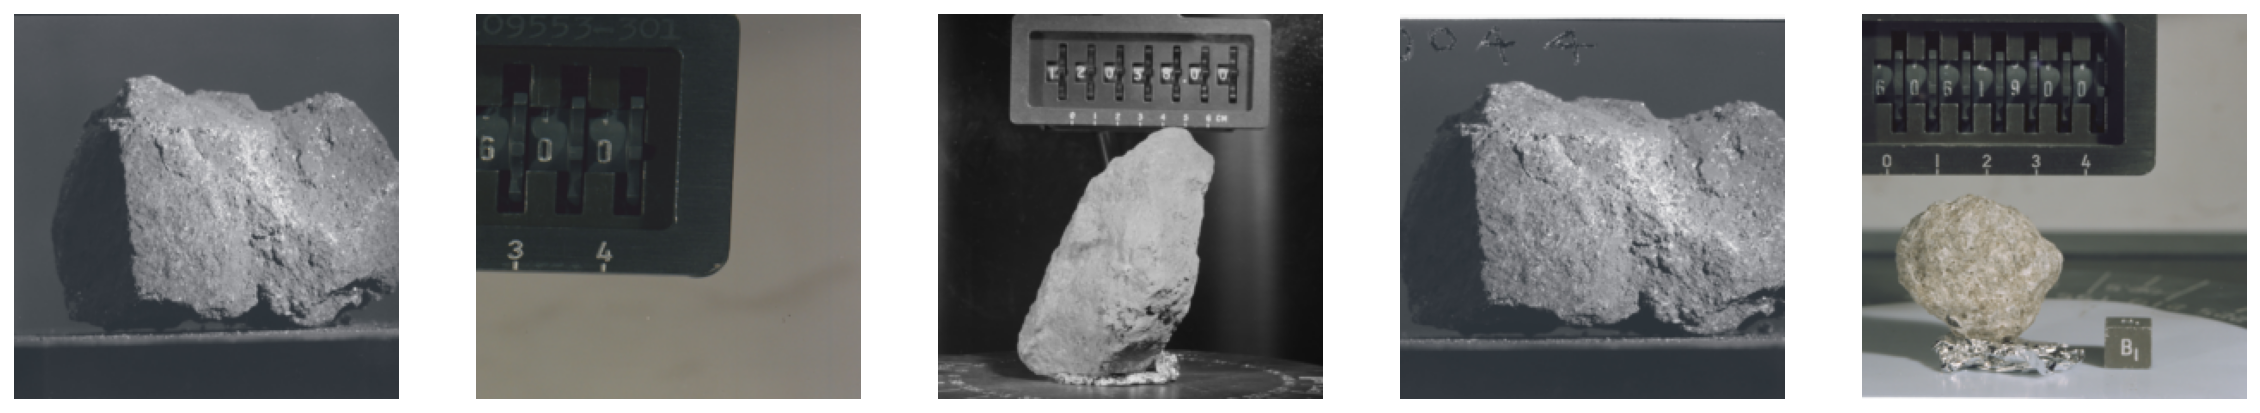

In [28]:
# How many images do you want to see? It's set to 5, but you can change the number.
images, labels = get_random_images(data_dir, 5)
to_pil = transforms.ToPILImage()
fig = plt.figure(figsize = (20,20))
classes=trainloader.dataset.classes
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [29]:
# Determine whether you're using a CPU or a GPU to build the deep learning network.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ResNet-50 is a convolutional neural network that is 50 layers deep.
model = models.resnet50(pretrained=True)
print(f"Is Cuda (GPU) Available? {torch.cuda.is_available()}")

Is Cuda (GPU) Available? False


In [30]:
# Builds all the neurons.
for param in model.parameters():
    param.requires_grad = False

# The parameters of our deep learning model.
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 2),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)
print('done')

done


In [31]:
# The epochs variable tells the program how many times to search for associations in features. It's initially 
# set to 5, but you can increase the number to increase the accuracy. 
# However, increasing the number makes the code run significantly slower.
# Even though 96% is high, you can take a couple more steps to increase accuracy even further:
#     Add more images, for training the AI models.
#     Increase the epoch (number of training iterations for deep learning).
epochs = 5
steps = 0
running_loss = 0
print_every = 5
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:

        steps += 1
        print('Training step ', steps)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Training step  1
Training step  2
Training step  3
Training step  4
Training step  5
Epoch 1/5.. Train loss: 3.225.. Test loss: 0.655.. Test accuracy: 0.577
Training step  6
Training step  7
Training step  8
Training step  9
Training step  10
Epoch 2/5.. Train loss: 0.864.. Test loss: 0.620.. Test accuracy: 0.775
Training step  11
Training step  12
Training step  13
Training step  14
Training step  15
Epoch 2/5.. Train loss: 0.687.. Test loss: 0.635.. Test accuracy: 0.677
Training step  16
Training step  17
Training step  18
Training step  19
Training step  20
Epoch 3/5.. Train loss: 0.571.. Test loss: 0.605.. Test accuracy: 0.777
Training step  21
Training step  22
Training step  23
Training step  24
Training step  25
Epoch 4/5.. Train loss: 0.438.. Test loss: 0.489.. Test accuracy: 0.840
Training step  26
Training step  27
Training step  28
Training step  29
Training step  30
Epoch 4/5.. Train loss: 0.420.. Test loss: 0.437.. Test accuracy: 0.838
Training step  31
Training step  32
T

In [33]:
#Save the model
torch.save(model, 'aerialmodel.pth')

In [34]:
# loads the neural network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('aerialmodel.pth')

In [35]:
# A function that predicts the new image type:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

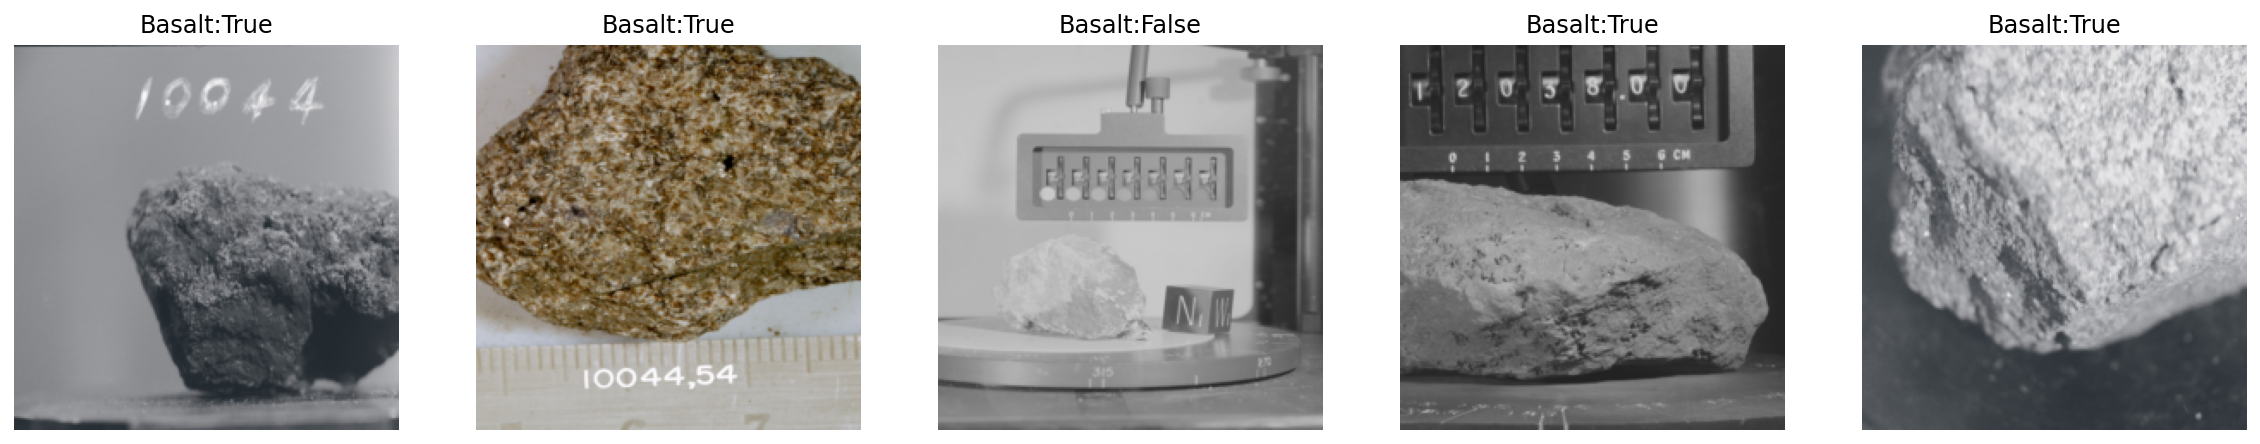

In [40]:
#Load 5 random images and predict
to_pil = transforms.ToPILImage()
images, labels = get_random_images(data_dir, 5)
fig = plt.figure(figsize=(20,10))

classes = trainloader.dataset.classes
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()